In [1]:
import cv2
import datetime as dt
import itertools
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
from keras import models, layers
from keras.applications import Xception
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from pathlib import Path
from sklearn.metrics import confusion_matrix

In [2]:
weights = Path('C:/Users/ilya-/Downloads/xception_weights_tf_dim_ordering_tf_kernels_notop.h5')
train_dir = Path('C:/Users/ilya-/Downloads/archive/training/training')
test_dir = Path('C:/Users/ilya-/Downloads/archive/validation/validation')

In [3]:
cols = ['Label','Latin Name', 'Common Name','Train Images', 'Validation Images']
labels = pd.read_csv('C:/Users/ilya-/Downloads/archive/monkey_labels.txt', names=cols, skiprows=1)
labels

,Label,Latin Name,Common Name,Train Images,Validation Images
0,n0,alouatta_palliata\t,mantled_howler,131,26
1,n1,erythrocebus_patas\t,patas_monkey,139,28
2,n2,cacajao_calvus\t,bald_uakari,137,27
3,n3,macaca_fuscata\t,japanese_macaque,152,30
4,n4,cebuella_pygmea\t,pygmy_marmoset,131,26
5,n5,cebus_capucinus\t,white_headed_capuchin,141,28
6,n6,mico_argentatus\t,silvery_marmoset,132,26
7,n7,saimiri_sciureus\t,common_squirrel_monkey,142,28
8,n8,aotus_nigriceps\t,black_headed_night_monkey,133,27
9,n9,trachypithecus_johnii,nilgiri_langur,132,26


(367, 550, 3)


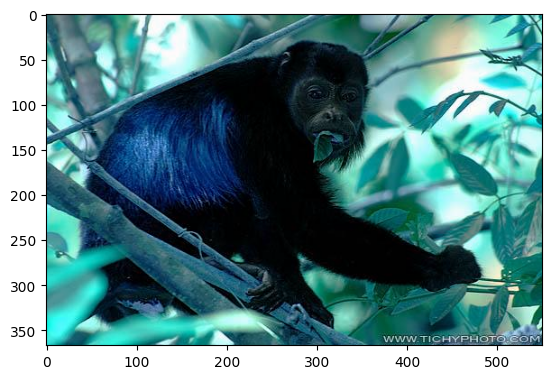

In [4]:
img = cv2.imread('C:/Users/ilya-/Downloads/archive/training/training/n0/n0018.jpg')
print(img.shape)
plt.imshow(img)

In [5]:
labels = labels['Common Name']
labels

0     mantled_howler                
1     patas_monkey                  
2     bald_uakari                   
3     japanese_macaque              
4     pygmy_marmoset                
5     white_headed_capuchin         
6     silvery_marmoset              
7     common_squirrel_monkey        
8     black_headed_night_monkey     
9     nilgiri_langur                
Name: Common Name, dtype: object

In [6]:
# параметры изображения
height=150
width=150
channels=3
# количество изображений в каждом блоке
batch_size=32
# фиксируем рандом
seed=42


# нормализация training
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(height,width),
                                                    batch_size=batch_size,
                                                    seed=seed,
                                                    class_mode='categorical')

# нормализация test
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_dir, 
                                                  target_size=(height,width), 
                                                  batch_size=batch_size,
                                                  seed=seed,
                                                  class_mode='categorical')

Found 1098 images belonging to 10 classes.
Found 272 images belonging to 10 classes.


In [8]:
# создание модели Xception
base_model = Xception(weights=weights,  # предворительно обученные веса модели
                      include_top=False,    # не включаю классификацию моделей, буду обучать самостоятельно
                      input_shape=(height, width, channels))


In [9]:
# извлечение признаков из изображений
def extract_features(sample_count, datagen):
    start = dt.datetime.now()
    features_shape = (sample_count, 5, 5, 2048)
    features = np.zeros(features_shape)
    labels = np.zeros(shape=(sample_count, 10))  # Assuming 10 classes based on your code
    generator = datagen
    i = 0
    for inputs_batch, labels_batch in generator:
        stop = dt.datetime.now()
        time = (stop - start).seconds
        print('\r',
              'извлечение признаков из блока', str(i+1), '/', len(datagen),
              '-- время выполнения', time,'секунд',
              end='')
        
        features_batch = base_model.predict(inputs_batch)
        
         # Динамически корректируем форму признаков в зависимости от реального числа образцов в блоке
        batch_size_actual = len(inputs_batch)
        features[i * batch_size : i * batch_size + batch_size_actual, :, :, :] = features_batch[:batch_size_actual]
        labels[i * batch_size : i * batch_size + batch_size_actual, :] = labels_batch[:batch_size_actual]
        i += 1
        
        if i * batch_size >= sample_count:
            break
            
    print("\n")
    return features, labels
train_features, train_labels = extract_features(1120, train_generator)
test_features, test_labels = extract_features(272, test_generator)

1/1 [==============================] - 6s 6s/stepыполнения 105 секу


1/1 [==============================] - 1s 1s/stepолнения 25 секу




In [10]:
# преобразование формы для массивов
flat_dim = 5 * 5 * 2048
train_features = np.reshape(train_features, (1120, flat_dim))
test_features = np.reshape(test_features, (272, flat_dim))

# снижение скорости для оптимизации и избежания переобучения
reduce_learning_rate = ReduceLROnPlateau(monitor='loss',
                                         factor=0.1,
                                         patience=2,
                                         cooldown=2,
                                         min_lr=0.00001,
                                         verbose=1)

callbacks = [reduce_learning_rate]

# компиляция модели
model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=flat_dim))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='softmax'))
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])

In [11]:
# обучение модели на предварительно извлечённых признаках с использованием данных обучения
history = model.fit(train_features, 
                    train_labels, 
                    epochs=30,
                    batch_size=batch_size,
                    shuffle=True,
                    validation_split=0.1,
                    callbacks=callbacks)

Epoch 1/30


32/32 [==============================] - 17s 446ms/step - loss: 5.3846 - acc: 0.7044 - val_loss: 1.5748 - val_acc: 0.6786 - lr: 0.0010
Epoch 2/30
32/32 [==============================] - 13s 421ms/step - loss: 1.2739 - acc: 0.8829 - val_loss: 1.0242 - val_acc: 0.6518 - lr: 0.0010
Epoch 3/30
32/32 [==============================] - 13s 407ms/step - loss: 0.5039 - acc: 0.9196 - val_loss: 0.8893 - val_acc: 0.6696 - lr: 0.0010
Epoch 4/30
32/32 [==============================] - 14s 448ms/step - loss: 0.3554 - acc: 0.9266 - val_loss: 0.7180 - val_acc: 0.7143 - lr: 0.0010
Epoch 5/30
32/32 [==============================] - 14s 446ms/step - loss: 0.3147 - acc: 0.9464 - val_loss: 0.5553 - val_acc: 0.7054 - lr: 0.0010
Epoch 6/30
32/32 [==============================] - 14s 437ms/step - loss: 0.2203 - acc: 0.9464 - val_loss: 0.5396 - val_acc: 0.7054 - lr: 0.0010
Epoch 7/30
32/32 [==============================] - 14s 422ms/step - loss: 0.2135 - acc: 0.9514 - val_loss: 1.0018 - val_a

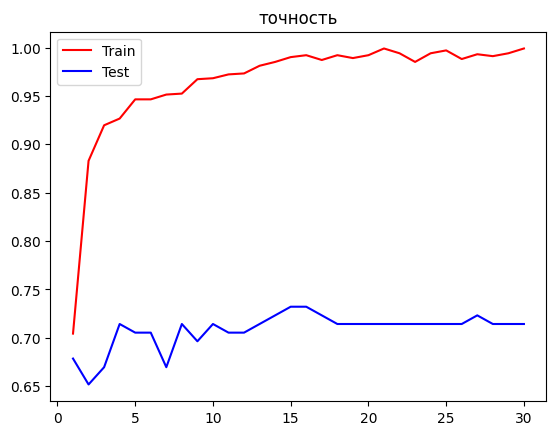

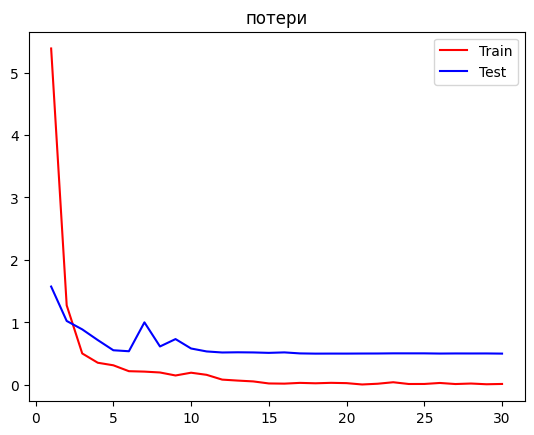

In [12]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('точность')
plt.plot(epochs, acc, 'red', label='Train')
plt.plot(epochs, val_acc, 'blue', label='Test'
         )
plt.legend()

plt.figure()
plt.title('потери')
plt.plot(epochs, loss, 'red', label='Train')
plt.plot(epochs, val_loss, 'blue', label='Test')

plt.legend()

plt.show()

In [13]:
# предсказание на тестовом наборе данных
preds = model.predict(test_features)
#преобразование в индексы классов
predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]

9/9 [==============================] - 0s 37ms/step


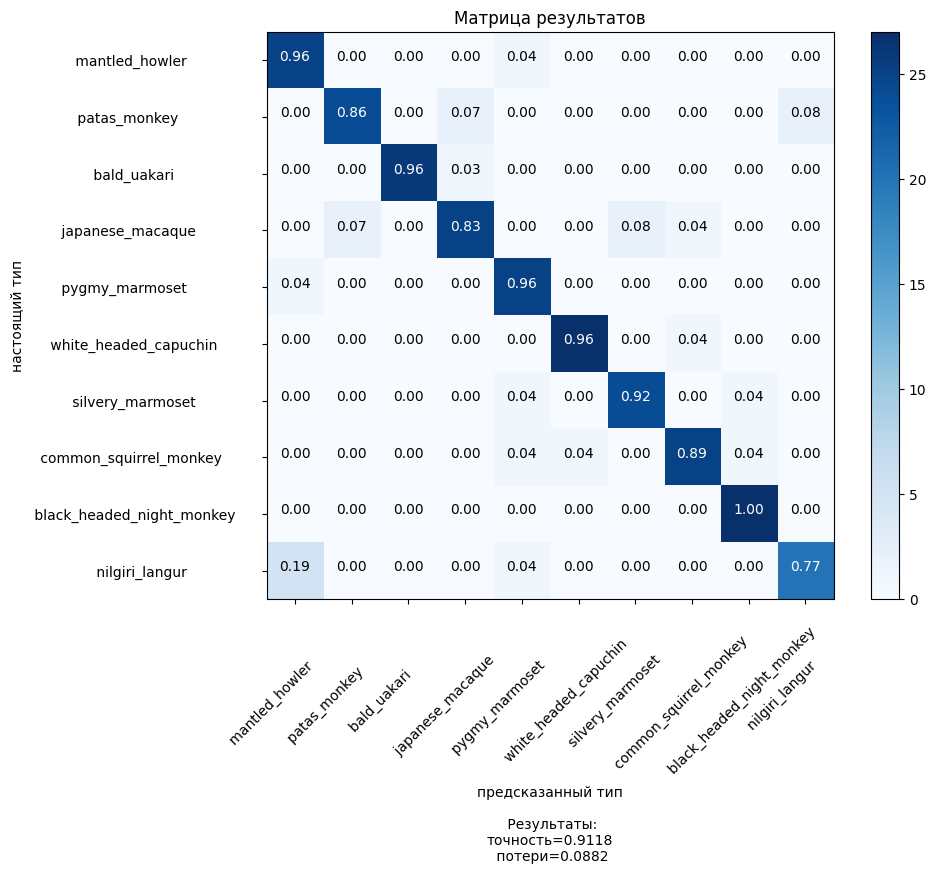

In [23]:
def plot_confusion_matrix(cm, target_names,title='Матрица результатов',cmap=None,normalize=False):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if cmap is None:
        cmap = plt.get_cmap('Blues')
    plt.figure(figsize=(10, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float32') / cm.sum(axis=1)
        cm = np.round(cm,2)

    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.2f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('настоящий тип')
    plt.xlabel("предсказанный тип\n\n Результаты:\nточность={:0.4f}\n потери={:0.4f}".format(accuracy, misclass))
    plt.show()    

cm = confusion_matrix(y_pred=predictions, y_true=y_true)
plot_confusion_matrix(cm, normalize=True, target_names=labels)    
